In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
sns.set_style("darkgrid")

In [12]:
missing_df = pd.read_parquet("../data/missing_fpmmTrades.parquet")

In [13]:
missing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24121 entries, 0 to 24120
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   collateralAmount               24121 non-null  object
 1   collateralAmountUSD            24121 non-null  object
 2   collateralToken                24121 non-null  object
 3   creationTimestamp              24121 non-null  object
 4   trader_address                 24121 non-null  object
 5   feeAmount                      24121 non-null  object
 6   id                             24121 non-null  object
 7   oldOutcomeTokenMarginalPrice   24121 non-null  object
 8   outcomeIndex                   24121 non-null  object
 9   outcomeTokenMarginalPrice      24121 non-null  object
 10  outcomeTokensTraded            24121 non-null  object
 11  title                          24121 non-null  object
 12  transactionHash                24121 non-null  object
 13  t

In [26]:
old_markets_df = pd.read_parquet("../data/old_fpmmTrades.parquet")

In [3]:
markets = pd.read_parquet('../data/fpmms.parquet')

In [35]:
trades_data = pd.read_parquet('../tmp/fpmmTrades.parquet')

In [ ]:
trades_filename = "new_fpmmTrades.parquet"

In [23]:
new_trades = pd.read_parquet("../tmp/new_fpmmTrades.parquet")

In [15]:
new_trades.columns

Index(['collateralAmount', 'collateralAmountUSD', 'collateralToken',
       'creationTimestamp', 'trader_address', 'feeAmount', 'id',
       'oldOutcomeTokenMarginalPrice', 'outcomeIndex',
       'outcomeTokenMarginalPrice', 'outcomeTokensTraded', 'title',
       'transactionHash', 'type', 'market_creator',
       'fpmm.answerFinalizedTimestamp', 'fpmm.arbitrationOccurred',
       'fpmm.currentAnswer', 'fpmm.id', 'fpmm.isPendingArbitration',
       'fpmm.openingTimestamp', 'fpmm.outcomes', 'fpmm.title',
       'fpmm.condition.id'],
      dtype='object')

In [36]:
from datetime import datetime, timezone
def transform_to_datetime(x):
    return datetime.fromtimestamp(int(x), tz=timezone.utc)


In [17]:
new_trades["creationTimestamp"] = new_trades["creationTimestamp"].apply(
        lambda x: transform_to_datetime(x)
)

In [37]:
def add_creation_date(df):
    try:
        df["creationTimestamp"] = df["creationTimestamp"].apply(
            lambda x: transform_to_datetime(x)
        )
    except Exception:
        print("Ignore")
    df["creation_timestamp"] = pd.to_datetime(df["creationTimestamp"])
    df["creation_date"] = df["creation_timestamp"].dt.date
    df["creation_date"] = pd.to_datetime(df["creation_date"])
    return df

In [27]:
old_markets_df = add_creation_date(old_markets_df)
max(old_markets_df.creation_date)

Ignore


Timestamp('2025-01-14 00:00:00')

In [38]:
trades_data = add_creation_date(trades_data)
max(trades_data.creation_date)

Ignore


Timestamp('2025-01-16 00:00:00')

In [39]:
min(trades_data.creation_date)

Timestamp('2024-11-14 00:00:00')

In [24]:
new_trades = add_creation_date(new_trades)
max(new_trades.creation_date)

Timestamp('2025-01-14 00:00:00')

In [25]:
min(new_trades.creation_date)

Timestamp('2025-01-11 00:00:00')

In [28]:
# lowercase and strip creator_address
new_trades["trader_address"] = (
    new_trades["trader_address"].str.lower().str.strip()
)
# ensure creationTimestamp compatibility
try:
    new_trades["creationTimestamp"] = new_trades["creationTimestamp"].apply(
        lambda x: transform_to_datetime(x)
    )

except Exception as e:
    print(f"Transformation not needed")
try:
    old_markets_df["creationTimestamp"] = old_markets_df["creationTimestamp"].apply(
        lambda x: transform_to_datetime(x)
    )
except Exception as e:
    print(f"Transformation not needed")

# merge two dataframes
merge_df = pd.concat([old_markets_df, new_trades], ignore_index=True)
# avoid numpy objects
merge_df["fpmm.arbitrationOccurred"] = merge_df["fpmm.arbitrationOccurred"].astype(
    bool
)
merge_df["fpmm.isPendingArbitration"] = merge_df[
    "fpmm.isPendingArbitration"
].astype(bool)

# Check for duplicates
print(f"Initial length before removing duplicates in fpmmTrades= {len(merge_df)}")

# Remove duplicates
# fpmm.outcomes is a numpy array
merge_df.drop_duplicates("id", keep="last", inplace=True)

Transformation not needed
Transformation not needed
Initial length before removing duplicates in fpmmTrades= 165530


In [29]:
merge_df.columns

Index(['collateralAmount', 'collateralAmountUSD', 'collateralToken',
       'creationTimestamp', 'trader_address', 'feeAmount', 'id',
       'oldOutcomeTokenMarginalPrice', 'outcomeIndex',
       'outcomeTokenMarginalPrice', 'outcomeTokensTraded', 'title',
       'transactionHash', 'type', 'market_creator',
       'fpmm.answerFinalizedTimestamp', 'fpmm.arbitrationOccurred',
       'fpmm.currentAnswer', 'fpmm.id', 'fpmm.isPendingArbitration',
       'fpmm.openingTimestamp', 'fpmm.outcomes', 'fpmm.title',
       'fpmm.condition.id', 'creation_timestamp', 'creation_date'],
      dtype='object')

In [30]:
max(merge_df.creation_date)

Timestamp('2025-01-14 00:00:00')

In [31]:
cutoff_date="2024-11-13"
min_date_utc = pd.to_datetime(cutoff_date, format="%Y-%m-%d", utc=True)

In [32]:
merge_df["creation_timestamp"] = pd.to_datetime(
    merge_df["creation_timestamp"], utc=True
)

print(f"length before filtering {len(merge_df)}")
merge_df = merge_df.loc[merge_df["creation_timestamp"] > min_date_utc]
print(f"length after filtering {len(merge_df)}")


length before filtering 161781
length after filtering 160426


In [33]:
max(merge_df.creation_date)

Timestamp('2025-01-14 00:00:00')

In [34]:
merge_df.to_parquet("../tmp/fpmmTrades.parquet", index=False)

In [15]:
missing_df = add_creation_date(missing_df)
missing_df.columns

Index(['collateralAmount', 'collateralAmountUSD', 'collateralToken',
       'creationTimestamp', 'trader_address', 'feeAmount', 'id',
       'oldOutcomeTokenMarginalPrice', 'outcomeIndex',
       'outcomeTokenMarginalPrice', 'outcomeTokensTraded', 'title',
       'transactionHash', 'type', 'market_creator',
       'fpmm.answerFinalizedTimestamp', 'fpmm.arbitrationOccurred',
       'fpmm.currentAnswer', 'fpmm.id', 'fpmm.isPendingArbitration',
       'fpmm.openingTimestamp', 'fpmm.outcomes', 'fpmm.title',
       'fpmm.condition.id', 'creation_timestamp', 'creation_date'],
      dtype='object')

<Axes: xlabel='Count', ylabel='creation_date'>

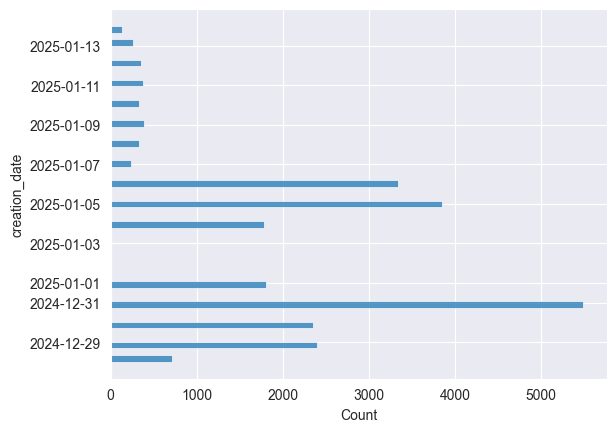

In [16]:
import seaborn as sns

sns.histplot(missing_df, y="creation_date")

<Axes: xlabel='Count', ylabel='creation_date'>

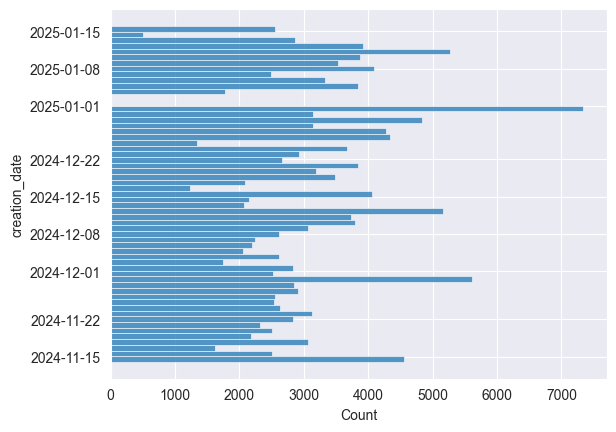

In [40]:
sns.histplot(trades_data, y="creation_date")

In [19]:
def add_extra_columns(new_trades):
    new_trades["creation_timestamp"] = pd.to_datetime(new_trades["creationTimestamp"])
    new_trades["creation_date"] = new_trades["creation_timestamp"].dt.date
    new_trades["creation_date"] = pd.to_datetime(new_trades["creation_date"])

In [ ]:
add_extra_columns(new_trades=new_trades)

In [9]:
max(new_trades.creation_date)

Timestamp('2025-01-13 00:00:00')

In [12]:
new_trades.columns

Index(['collateralAmount', 'collateralAmountUSD', 'collateralToken',
       'creationTimestamp', 'trader_address', 'feeAmount', 'id',
       'oldOutcomeTokenMarginalPrice', 'outcomeIndex',
       'outcomeTokenMarginalPrice', 'outcomeTokensTraded', 'title',
       'transactionHash', 'type', 'market_creator',
       'fpmm.answerFinalizedTimestamp', 'fpmm.arbitrationOccurred',
       'fpmm.currentAnswer', 'fpmm.id', 'fpmm.isPendingArbitration',
       'fpmm.openingTimestamp', 'fpmm.outcomes', 'fpmm.title',
       'fpmm.condition.id', 'creation_timestamp', 'creation_date'],
      dtype='object')

In [23]:
old_trades_df = pd.read_parquet("../tmp/fpmmTrades.parquet")


# lowercase and strip creator_address
new_trades["trader_address"] = (
    new_trades["trader_address"].str.lower().str.strip()
)


try:
    old_trades_df["creationTimestamp"] = old_trades_df["creationTimestamp"].apply(
        lambda x: transform_to_datetime(x)
    )
except Exception as e:
    print(f"Transformation not needed")

# merge two dataframes
merge_df = pd.concat([old_trades_df, new_trades], ignore_index=True)
# avoid numpy objects
merge_df["fpmm.arbitrationOccurred"] = merge_df["fpmm.arbitrationOccurred"].astype(
    bool
)
merge_df["fpmm.isPendingArbitration"] = merge_df[
    "fpmm.isPendingArbitration"
].astype(bool)

# Check for duplicates
print(f"Initial length before removing duplicates in fpmmTrades= {len(merge_df)}")

# Remove duplicates
# fpmm.outcomes is a numpy array
merge_df.drop_duplicates("id", keep="last", inplace=True)
print(f"Final length after removing duplicates in fpmmTrades= {len(merge_df)}")

Transformation not needed
Initial length before removing duplicates in fpmmTrades= 137851
Final length after removing duplicates in fpmmTrades= 137851


In [24]:
merge_df.to_parquet("../tmp/fpmmTrades.parquet", index=False)

In [13]:
old_trades_df.columns

Index(['collateralAmount', 'collateralAmountUSD', 'collateralToken',
       'creationTimestamp', 'trader_address', 'feeAmount', 'id',
       'oldOutcomeTokenMarginalPrice', 'outcomeIndex',
       'outcomeTokenMarginalPrice', 'outcomeTokensTraded', 'title',
       'transactionHash', 'type', 'market_creator',
       'fpmm.answerFinalizedTimestamp', 'fpmm.arbitrationOccurred',
       'fpmm.currentAnswer', 'fpmm.id', 'fpmm.isPendingArbitration',
       'fpmm.openingTimestamp', 'fpmm.outcomes', 'fpmm.title',
       'fpmm.condition.id', 'creation_timestamp', 'creation_date'],
      dtype='object')

In [20]:
add_extra_columns(new_trades=merge_df)

In [21]:
merge_df.columns

Index(['collateralAmount', 'collateralAmountUSD', 'collateralToken',
       'creationTimestamp', 'trader_address', 'feeAmount', 'id',
       'oldOutcomeTokenMarginalPrice', 'outcomeIndex',
       'outcomeTokenMarginalPrice', 'outcomeTokensTraded', 'title',
       'transactionHash', 'type', 'market_creator',
       'fpmm.answerFinalizedTimestamp', 'fpmm.arbitrationOccurred',
       'fpmm.currentAnswer', 'fpmm.id', 'fpmm.isPendingArbitration',
       'fpmm.openingTimestamp', 'fpmm.outcomes', 'fpmm.title',
       'fpmm.condition.id', 'creation_timestamp', 'creation_date'],
      dtype='object')

In [22]:
max(merge_df.creation_date)

Timestamp('2025-01-13 00:00:00')

In [9]:
merge_df = pd.concat([trades_data, new_trades], ignore_index=True)

In [10]:
merge_df["fpmm.arbitrationOccurred"] = merge_df["fpmm.arbitrationOccurred"].astype(
    bool
)

In [11]:
merge_df["fpmm.isPendingArbitration"] = merge_df[
        "fpmm.isPendingArbitration"
    ].astype(bool)

In [12]:
 print(f"Initial length before removing duplicates in fpmmTrades= {len(merge_df)}")

Initial length before removing duplicates in fpmmTrades= 123556


In [13]:
merge_df.drop_duplicates("id", inplace=True)
print(f"Final length after removing duplicates in fpmmTrades= {len(merge_df)}")

Final length after removing duplicates in fpmmTrades= 117771


In [14]:
merge_df.to_parquet("../tmp/fpmmTrades.parquet", index=False)

In [6]:
trades_data.columns

Index(['collateralAmount', 'collateralAmountUSD', 'collateralToken',
       'creationTimestamp', 'trader_address', 'feeAmount', 'id',
       'oldOutcomeTokenMarginalPrice', 'outcomeIndex',
       'outcomeTokenMarginalPrice', 'outcomeTokensTraded', 'title',
       'transactionHash', 'type', 'market_creator',
       'fpmm.answerFinalizedTimestamp', 'fpmm.arbitrationOccurred',
       'fpmm.currentAnswer', 'fpmm.id', 'fpmm.isPendingArbitration',
       'fpmm.openingTimestamp', 'fpmm.outcomes', 'fpmm.title',
       'fpmm.condition.id'],
      dtype='object')

In [5]:
len(trades_data)

102664

In [ ]:
max(fpmmsTra)

In [4]:
markets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4688 entries, 0 to 4687
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   currentAnswer   4688 non-null   object
 1   id              4688 non-null   object
 2   title           4688 non-null   object
 3   market_creator  4688 non-null   object
dtypes: object(4)
memory usage: 146.6+ KB


In [5]:
markets.currentAnswer.value_counts()

currentAnswer
No       2771
Yes      1914
no          1
False       1
IND         1
Name: count, dtype: int64

In [6]:
fpmms.head()

currentAnswer                                          id  \
0            No  0x0017cd58d6a7ee1451388c7d5b1051b4c0a041f5   
1            No  0x0020d13c89140b47e10db54cbd53852b90bc1391   
2            No  0x003ae5e007cc38b3f86b0ed7c82f938a1285ac07   
3           Yes  0x004c8d4c619dc6b9caa940f5ea7ef699ae85359c   
4           Yes  0x005e3f7a90585acbec807425a750fbba1d0c2b5c   

                                               title market_creator  
0  Will the first floating offshore wind research...     quickstart  
1  Will the Francis Scott Key Bridge in Baltimore...     quickstart  
2  Will FC Saarbrucken reach the final of the Ger...     quickstart  
3  Will the pro-life activists convicted for 'con...     quickstart  
4  Will Apple announce the release of a new M4 ch...     quickstart

In [9]:
fpmms.currentAnswer.value_counts()

currentAnswer
No       2583
Yes      1833
no          1
False       1
IND         1
Name: count, dtype: int64

In [7]:
fpmms.market_creator.value_counts()

market_creator
quickstart    4252
pearl          167
Name: count, dtype: int64

In [8]:
fpmms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4419 entries, 0 to 4418
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   currentAnswer   4419 non-null   object
 1   id              4419 non-null   object
 2   title           4419 non-null   object
 3   market_creator  4419 non-null   object
dtypes: object(4)
memory usage: 138.2+ KB


In [4]:
fpmms.currentAnswer.value_counts()

currentAnswer
No       2495
Yes      1746
no          1
False       1
IND         1
Name: count, dtype: int64

In [4]:
fpmms.currentAnswer.value_counts()

currentAnswer
No       2170
Yes      1500
no          1
False       1
IND         1
Name: count, dtype: int64

In [5]:
fpmms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3673 entries, 0 to 3672
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             3673 non-null   object
 1   currentAnswer  3673 non-null   object
 2   title          3673 non-null   object
dtypes: object(3)
memory usage: 86.2+ KB


In [3]:
all_trades = pd.read_parquet('../data/all_trades_profitability.parquet')

In [5]:
all_trades.is_invalid.value_counts()

is_invalid
False    23830
True      3877
Name: count, dtype: int64

In [7]:
mask = (all_trades["is_invalid"] & all_trades["redeemed"])
filtered_trades = all_trades[~mask]
len(filtered_trades)

24722

In [4]:
len(all_trades)

27707

In [8]:
len(filtered_trades)

24722

In [9]:
filtered_trades.winning_trade.value_counts()

winning_trade
True     13133
False    11589
Name: count, dtype: int64

In [10]:
filtered_trades["creation_timestamp"] = pd.to_datetime(filtered_trades["creation_timestamp"])

/var/folders/gp/02mb1d514ng739czlxw1lhh00000gn/T/ipykernel_82376/982645160.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_trades["creation_timestamp"] = pd.to_datetime(filtered_trades["creation_timestamp"])


In [11]:
filtered_trades.current_answer.value_counts()

current_answer
 1    13016
 0    10814
-1      892
Name: count, dtype: int64

In [38]:
len(list(all_trades.trader_address.unique()))

203

In [25]:
len(all_trades)

27707

In [13]:
all_trades['month_year'] = all_trades['creation_timestamp'].dt.to_period('M').astype(str)
all_trades['month_year_week'] = all_trades['creation_timestamp'].dt.to_period('W').astype(str)
all_trades['winning_trade'] = all_trades['winning_trade'].astype(int)
all_trades.winning_trade.value_counts()

/var/folders/gp/02mb1d514ng739czlxw1lhh00000gn/T/ipykernel_70112/183699308.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  all_trades['month_year'] = all_trades['creation_timestamp'].dt.to_period('M').astype(str)
/var/folders/gp/02mb1d514ng739czlxw1lhh00000gn/T/ipykernel_70112/183699308.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  all_trades['month_year_week'] = all_trades['creation_timestamp'].dt.to_period('W').astype(str)


winning_trade
0    14574
1    13133
Name: count, dtype: int64

In [14]:
winning_trades = all_trades.groupby(['month_year_week'])['winning_trade'].sum() / all_trades.groupby(['month_year_week'])['winning_trade'].count() * 100
# winning_trades is a series, give it a dataframe
winning_trades = winning_trades.reset_index()
winning_trades.columns = winning_trades.columns.astype(str)
winning_trades.columns = ['month_year_week', 'winning_trade']
winning_trades

month_year_week  winning_trade
0  2024-04-22/2024-04-28      60.465116
1  2024-04-29/2024-05-05      53.887043
2  2024-05-06/2024-05-12      49.626201
3  2024-05-13/2024-05-19      47.931617
4  2024-05-20/2024-05-26      46.209810
5  2024-05-27/2024-06-02      41.855369
6  2024-06-03/2024-06-09      43.714888
7  2024-06-10/2024-06-16      46.697039
8  2024-06-17/2024-06-23      52.762120

In [28]:
that_week = winning_trades[winning_trades["month_year_week"]=="2024-06-03/2024-06-09"]
that_week

month_year_week  winning_trade
6  2024-06-03/2024-06-09      43.714888

In [15]:
winning_trades2 = all_trades.groupby(['month_year_week'])['winning_trade'].agg(["sum","count"]).reset_index()
winning_trades2

month_year_week   sum  count
0  2024-04-22/2024-04-28    26     43
1  2024-04-29/2024-05-05  1622   3010
2  2024-05-06/2024-05-12  2788   5618
3  2024-05-13/2024-05-19  2271   4738
4  2024-05-20/2024-05-26  1969   4261
5  2024-05-27/2024-06-02  1719   4107
6  2024-06-03/2024-06-09  1245   2848
7  2024-06-10/2024-06-16  1025   2195
8  2024-06-17/2024-06-23   468    887

In [29]:
that_week = winning_trades2[winning_trades2["month_year_week"]=="2024-06-03/2024-06-09"]
that_week

month_year_week   sum  count  winning_trade
6  2024-06-03/2024-06-09  1245   2848      43.714888

In [18]:
INC_TOOLS = [
    "prediction-online",
    "prediction-offline",
    "claude-prediction-online",
    "claude-prediction-offline",
    "prediction-offline-sme",
    "prediction-online-sme",
    "prediction-request-rag",
    "prediction-request-reasoning",
    "prediction-url-cot-claude",
    "prediction-request-rag-claude",
    "prediction-request-reasoning-claude",
]

In [60]:
tools = pd.read_parquet('../data/tools.parquet')

In [61]:
tools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127674 entries, 0 to 127673
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   request_id               127674 non-null  object 
 1   request_block            127674 non-null  int64  
 2   prompt_request           127674 non-null  object 
 3   tool                     127674 non-null  object 
 4   nonce                    127674 non-null  object 
 5   trader_address           127674 non-null  object 
 6   deliver_block            127674 non-null  int64  
 7   error                    127668 non-null  float64
 8   error_message            19534 non-null   object 
 9   prompt_response          120607 non-null  object 
 10  mech_address             127674 non-null  object 
 11  p_yes                    108134 non-null  float64
 12  p_no                     108134 non-null  float64
 13  confidence               108134 non-null  float64
 14  info

In [62]:
tools.currentAnswer.value_counts()

currentAnswer
No     51140
Yes    37190
Name: count, dtype: int64

In [26]:
len(tools)

127674

In [31]:
tools_inc = tools[tools['tool'].isin(INC_TOOLS)]
tools_non_error = tools_inc[tools_inc['error'] != 1]
tools_non_error.loc[:, 'currentAnswer'] = tools_non_error['currentAnswer'].replace({'no': 'No', 'yes': 'Yes'})
tools_non_error = tools_non_error[tools_non_error['currentAnswer'].isin(['Yes', 'No'])]
tools_non_error = tools_non_error[tools_non_error['vote'].isin(['Yes', 'No'])]
tools_non_error['win'] = (tools_non_error['currentAnswer'] == tools_non_error['vote']).astype(int)
tools_non_error.columns = tools_non_error.columns.astype(str)
wins = tools_non_error.groupby(['tool', 'request_month_year_week', 'win']).size().unstack().fillna(0)

In [63]:
wins

win                                                   0      1
tool                      request_month_year_week             
claude-prediction-offline 2024-04-22/2024-04-28    14.0   23.0
                          2024-04-29/2024-05-05    34.0   99.0
                          2024-05-06/2024-05-12    22.0   34.0
                          2024-05-13/2024-05-19    40.0   52.0
                          2024-05-20/2024-05-26    18.0   52.0
...                                                 ...    ...
prediction-url-cot-claude 2024-05-06/2024-05-12    67.0   91.0
                          2024-05-13/2024-05-19    28.0   43.0
                          2024-05-20/2024-05-26    64.0  145.0
                          2024-05-27/2024-06-02    81.0  112.0
                          2024-06-03/2024-06-09     7.0   41.0

[91 rows x 2 columns]

In [56]:
selected_traders = list(tools.trader_address.unique())
len(selected_traders)

186

In [59]:
len(list(tools_non_error.trader_address.unique()))

182

In [36]:
len(tools)-len(tools_inc)

10817

In [32]:
tools_week = tools_non_error[tools_non_error["request_month_year_week"]=="2024-06-03/2024-06-09"]
len(tools_week)

11778

In [44]:
filtered_trades = all_trades.loc[all_trades["trader_address"].isin(selected_traders)]
len(filtered_trades)

0

In [45]:
all_addresses = list(all_trades.trader_address.unique())

In [58]:
for a in all_addresses:
    if a in selected_traders:
        print("found")

In [57]:
for a in selected_traders:
    if a in all_addresses:
        print("found")

In [46]:
filtered_tools = tools[tools["trader_address"].isin(all_addresses)]
len(filtered_tools)

0

In [55]:
all_trades.num_mech_calls.describe()

count    27707.000000
mean         3.912224
std          4.622220
min          0.000000
25%          1.000000
50%          2.000000
75%          5.000000
max         66.000000
Name: num_mech_calls, dtype: float64